In [1]:
#Homework 2
#Nathan Taylor
#01/25/22

In [2]:
import cirq
import random
import matplotlib.pyplot as plt
import numpy as np
import random as rand
from cirq.contrib.svg import SVGCircuit, circuit_to_svg

In [3]:
#Problem 1 - Functions
def rotate3z(i, j, k, qbits, anc, theta):
    ops = []
    
    ops.append(cirq.CNOT(qbits[i],anc))
    ops.append(cirq.CNOT(qbits[j],anc))
    ops.append(cirq.CNOT(qbits[k],anc))
    
    ops.append(cirq.rz(2*theta)(anc))
    
    ops.append(cirq.CNOT(qbits[k],anc))
    ops.append(cirq.CNOT(qbits[j],anc))
    ops.append(cirq.CNOT(qbits[i],anc))
    
    return ops

def rotate3x(i, j, k, qbits, anc, theta):
    ops = []
    hadamard = cirq.Moment(cirq.H(qbits[i]),cirq.H(qbits[j]),cirq.H(qbits[k]))
    ops.append(hadamard)
    ops.append(rotate3z(i, j, k, qbits, anc, theta))
    ops.append(hadamard)
    
    return ops

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


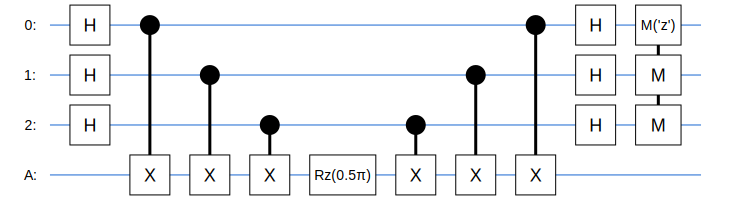

In [4]:
qubits = cirq.LineQubit.range(3)
ancilla = cirq.NamedQubit("A")
circuit = cirq.Circuit(rotate3x(0,1,2,qubits, ancilla, np.pi/4))
circuit.append(cirq.measure(*qubits,key='z'))
SVGCircuit(cirq.Circuit(circuit))

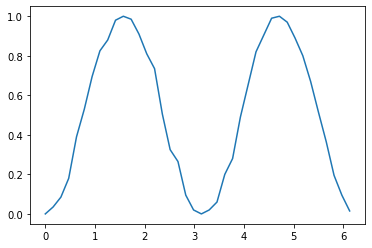

In [5]:
#Simulate - takes a while
sim = cirq.Simulator()

n=40#steps - fineness
theta = []
prob7 = []
for x in range(n):
    t = x*2*np.pi/n#length
    qubits = cirq.LineQubit.range(3)
    ancilla = cirq.NamedQubit("A")
    circuit = cirq.Circuit(rotate3x(0,1,2,qubits, ancilla, t))
    circuit.append(cirq.measure(*qubits,key='z'))
    
    count = 0
    runs = 200#accuracy
    for y in range(runs):
        out_state = sim.run(circuit)#Run it once
        a = "".join(str(out_state).split(", "))#Parse Output
        b=a[2:len(a)]
        if b=="111":
            count += 1
    prob7.append(count/runs)
    theta.append(t)
    
plt.plot(theta, prob7)

In [6]:
#Problem 2 Functions

def makeHp():
    #Make Hp
    Hp = []
    V = []
    
    #all qubits must be included, each qubit can only appear once per triplet
    check6 = [0,0,0,0,0,0]#check for all qubits present
    
    for x in range(12):
        unique = [0,1,2,3,4,5]
        triple = [0,0,0,0]#qubit indices and the weight at the end
        for y in range(3):
            triple[y]= unique[rand.randint(0,len(unique)-1)]
            triple[3] = int(2*(rand.randint(0,1)-1/2))#-1 or 1
            check6[triple[y]]+=1
            unique.remove(triple[y])
        Hp.append(triple)
    
    #recursive until all qubits are present
    for i in check6:
        if i == 0:
            Hp = makeHp()
            break;
    Hp = np.array(Hp)
    return Hp

def getEnergy(Hp,state):
    energy = 0
    for triple in Hp:
        Vsign = 1
        for q in range(3):
            if not state[triple[q]]:#if the qubit does not appear in the state, it gets a -1
                Vsign *= -1
        energy += triple[3]*Vsign#+- the weight depending on the number of qubits in a state
    return energy

#getEnergy(Hp, [0,1,0,1,1,0])        

def solveHp(Hp):
    #Find Ground State and Corresponding Energy
    stateList = []
    for a in range(2):#iterate through all possible states for 6 qubits
        for b in range(2):
            for c in range(2):
                for d in range(2):
                    for e in range(2):
                        for f in range(2):
                            stateList.append([a,b,c,d,e,f])
    
    g_states = []
    g_energy = 100#something not possible
    for s in stateList:
        s_energy = getEnergy(Hp, s)
        
        if s_energy < g_energy:
            g_energy = s_energy
            g_states = [s]
        elif s_energy == g_energy:
            g_states.append(s)
            
    return g_states, g_energy

#Convert state key into proper format (binary list)
def key_to_state(key, qubits):
    binaryformat = "{0:0" + str(len(qubits)) + "b}"
    bitstate = binaryformat.format(int(key))#Convert to binary to get the state as a string
    state = [0]*len(qubits)
    for i in range(len(bitstate)):
        if bitstate[i] == '1':
            state[i] = 1
    return state
    

#Finds the expectation value of a measurement in the z basis
def expectHp(oplist, qubits, H_p, gs_energy):
    sim = cirq.Simulator()
    circuit = cirq.Circuit(oplist)
    
    counts = 1000
    samples = sim.run(circuit, repetitions=counts)
    data = samples.histogram(key='z')#Returns the state and the number of times it was hit
    
    energy_avg = 0 #The average energy of the resulting state for the circuit
    ground_avg = 0 #Average times a ground state was hit
    
    #Dictionary: key = qubit state measurement, value = number of results
    for key, value in data.items():
        true_state = key_to_state(int(key), qubits)#Get the state it hit
        energy3Z = getEnergy(H_p, true_state)#The energy of the state
        energy_avg += int(value) * energy3Z
        if energy3Z == gs_energy:#The state is a ground state
            ground_avg += int(value)
        
    energy_avg /= counts#the average energy
    ground_avg /= counts#number of times the ground state was recovered
    return [energy_avg, ground_avg]

def makeQAOA_1layer(qubits, anc, H_p, alpha, beta):
    c_ops = []
    for q in qubits:
        c_ops.append(cirq.H(q))

    for triple in H_p:
        c_ops.append(rotate3z(triple[0],triple[1],triple[2], qubits, anc, alpha))
    for q in qubits:
        c_ops.append(cirq.rx(2*beta)(q))
        
    #Measure
    c_ops.append(cirq.measure(*qubits,key='z'))
    return c_ops

def makeQAOA_2layer(qubits, anc, H_p, angle_list):
    c_ops = []
    #Spp
    for q in qubits:
        c_ops.append(cirq.H(q))
        
    for i in range(int(len(angle_list)/2)):#alpha and beta angles are meshed into one so we need to separate them
        for triple in H_p:
            c_ops.append(rotate3z(triple[0],triple[1],triple[2], qubits, anc, angle_list[i*2]))
        for q in qubits:
            c_ops.append(cirq.rx(2*angle_list[i*2+1])(q))

    #Measure
    c_ops.append(cirq.measure(*qubits,key='z'))
    return c_ops

def makeQAOA_1layer_noise(qubits, anc, H_p, alpha, beta, err_num):
    c_ops = []
    for q in qubits:
        c_ops.append(cirq.H(q))

    for triple in H_p:
        c_ops.append(rotate3z(triple[0],triple[1],triple[2], qubits, anc, alpha))
            
    for q in qubits:
        c_ops.append(cirq.rx(2*beta)(q))
        
    #choose random qubit
    for i in range(err_num):
        single = []
        err_layer = rand.randint(0,len(c_ops)-1)#choose layer
        err_qubit = rand.randint(0, len(qubits)-1)#choose qubit
        err_gate = rand.randint(0,2)
        gates = [cirq.X,cirq.Y,cirq.Z]
        c_ops.insert(err_layer, gates[err_gate](qubits[err_qubit]))
        c_ops.append(cirq.measure(*qubits,key='z'))
    return c_ops

In [14]:
#2a)
H_p = makeHp()#This defines H_p for the rest of the hw, rerun this cell to change it
ground_states, ground_energy = solveHp(H_p)
print("Ground States: ", ground_states)
print("Ground Energy: ", ground_energy)

Ground States:  [[1, 1, 1, 1, 0, 0]]
Ground Energy:  -6


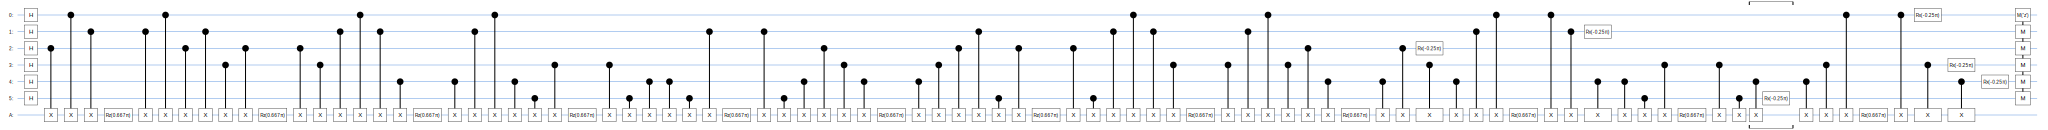

In [15]:
#2b) make 1 layer of QAOA
ground_states, ground_energy = solveHp(H_p)
qubits = cirq.LineQubit.range(6)
anc = cirq.NamedQubit("A")
circuit = makeQAOA_1layer(qubits, anc, H_p, np.pi/3, -np.pi/8)
SVGCircuit(cirq.Circuit(circuit))

In [16]:
#Optimize alpha and beta for 1 layer
dim = 10
angles = np.linspace(-np.pi/2, np.pi/2, num=dim)

optimal2 = [0, 0, 0, 0]
for i in range(dim):
    for j in range(dim):
        circuit = makeQAOA_1layer(qubits, anc, H_p, angles[i], angles[j])
        s_energy, g_prob = expectHp(circuit,qubits,H_p,ground_energy)
        if s_energy < optimal2[2]:
            optimal2 = [angles[i], angles[j], s_energy, g_prob]
            

print("Best Statistics")
print("Alpha: ", optimal2[0])
print("Beta: ", optimal2[1])
print("Expected Energy: ", optimal2[2])
print("Probability of Ground State: ", optimal2[3]*100,"%")

Best Statistics
Alpha:  1.2217304763960306
Beta:  0.8726646259971647
Expected Energy:  -0.802
Probability of Ground State:  3.3000000000000003 %


In [20]:
#2c)
#Brute force (at first)
#Optimize alpha and beta
#This takes like 5m to run, so just don't
dim = 10
angles = np.linspace(-np.pi/2, np.pi/2, num=dim)

optimal4 = [0, 0, 0, 0, 0, 0]
for i in angles:
    for j in angles:
        for k in angles:
            for l in angles:
                circuit2 = makeQAOA_2layer(qubits, anc, H_p, [i, j, k, l])
                s_energy, g_prob = expectHp(circuit2,qubits,H_p,ground_energy)
                if s_energy < optimal4[4]:
                    optimal4 = [i, j, k, l, s_energy, g_prob]
                    
print("Best Statistics")
print("3ZAngle1: ", optimal4[0])
print("RxAngle1: ", optimal4[1])
print("3ZAngle2: ", optimal4[2])
print("RxAngle2: ", optimal4[3])
print("Expected Energy: ", optimal4[4])
print("Probability of Ground State: ", optimal4[5]*100,"%")

Best Statistics
3ZAngle1:  -1.5707963267948966
RxAngle1:  0.17453292519943298
3ZAngle2:  0.17453292519943298
RxAngle2:  -0.8726646259971648
Expected Energy:  -1.418
Probability of Ground State:  8.9 %


In [17]:
#2c) Steepest Descent Optimization with k layers of QAOA
#Basic Version: 10, 10, 2
#Adding more layers can get way better results

dim = 10#how fine the sweep is - Quadratic Time Scale
iterations = 10#how many times to run the algorithm and compare - Linear Time Scale
layer_count = 2#how many layers to perform - flexibility     - Quadratic Time Scale

angles = np.linspace(-np.pi/2, np.pi/2, num=dim)
best_pos = np.zeros(2*layer_count)#no idea tbh
best_energy = 100

for i in range(iterations):
    c_pos = np.random.randint(len(angles),size=layer_count*2)
    print("\nStarting Location: ",c_pos)
    
    energy_low = 100
    while True:
        #List of adjacent states(angle sets)
        state_set = []
        state_low = c_pos#starting state at the beginning of the round
        for j in range(len(c_pos)):
            if c_pos[j] + 1 < dim:#add angle up and down to the list of states to check
                s = c_pos.copy()
                s[j] += 1
                state_set.append(s)
            if c_pos[j] - 1 >= 0:
                s = c_pos.copy()
                s[j] -= 1
                state_set.append(s)

                #Find the energies of all the states and choose the lowest one        
        for s in state_set:
            angle_list = [] #alpha and beta lists meshed together
            for qidx in s:
                angle_list.append(angles[qidx])
            
            circuit3 = makeQAOA_2layer(qubits, anc, H_p, angle_list)
            s_energy,prob = expectHp(circuit3,qubits,H_p,ground_energy)
            if s_energy < energy_low:
                state_low = s
                energy_low = s_energy
        #print("Low State: ", state_low)
        #Check if s == cpos (it hasn't moved) termination condition for local minima
        
        if np.array_equal(state_low, c_pos):#FIND THE NUMPY DOCUMENTATION FOR COMPARING ARRAYS
            print("Local Min: ", state_low, "Energy: ", energy_low)
            break
        else:
            c_pos = state_low#Update intermediate score

    #Update big score
    if energy_low < best_energy:
        best_energy = energy_low
        best_pos = c_pos

#Recalculate stats of best state
angle_list = [] #alpha and beta lists meshed together
for qidx in best_pos:
    angle_list.append(angles[qidx])

topcirc = makeQAOA_2layer(qubits, anc, H_p, angle_list)
best_energy,ground_prob = expectHp(topcirc,qubits,H_p,ground_energy)

alpha_list = np.array([])
beta_list = np.array([])
for i in range(int(len(angle_list)/2)):
    alpha_list = np.append(alpha_list, angle_list[i*2])
    beta_list = np.append(beta_list, angle_list[i*2+1])

print("Best Statistics")
print("State: ", best_pos)
print("3ZAngles: ", alpha_list)
print("RxAngles: ", beta_list)
print("Expected Energy: ", best_energy)
print("Probability of Ground State: ", ground_prob*100,"%")


Starting Location:  [1 4 8 8]
Local Min:  [1 4 7 9] Energy:  -0.174

Starting Location:  [1 9 7 8]
Local Min:  [1 8 5 8] Energy:  -0.976

Starting Location:  [8 6 3 7]
Local Min:  [9 6 4 7] Energy:  -1.224

Starting Location:  [5 0 3 3]
Local Min:  [6 0 2 2] Energy:  -1.13

Starting Location:  [0 9 7 5]
Local Min:  [0 9 8 5] Energy:  -0.146

Starting Location:  [7 7 2 0]
Local Min:  [7 8 2 1] Energy:  -0.454

Starting Location:  [3 4 9 6]
Local Min:  [4 4 9 6] Energy:  -0.91

Starting Location:  [2 0 0 8]
Local Min:  [2 1 1 8] Energy:  -0.192

Starting Location:  [4 7 9 1]
Local Min:  [4 8 9 1] Energy:  -0.538

Starting Location:  [4 2 1 9]
Local Min:  [6 2 1 9] Energy:  -0.644
Best Statistics
State:  [9 6 4 7]
3ZAngles:  [ 1.57079633 -0.17453293]
RxAngles:  [0.52359878 0.87266463]
Expected Energy:  -1.032
Probability of Ground State:  7.000000000000001 %


I chose both steepest descent and brute force to compare the methods. I wanted to see how good steepest descent was. Turns out, its pretty good and way faster. 2 Layers is a definite improvement. The extra degrees of freedom means we can get closer to the true ground state. Its still pretty far away though, which tells me that we would need a lot of layers to get near the actual ground state. The other apparent problem is that this is not comparable to the speed of solving Hp, at least for these small scall tests. Its also unfair to say that because were simulating a quantum computer with a classical computer which is inherently slow.

In [18]:
#3. QAOA and Noise
#a)

e1_list = []
g1_list = []

for i in range(100):
    e1_circuit=makeQAOA_1layer_noise(qubits, anc, H_p, optimal2[0], optimal2[1], 1)
    e1_energy, g1_prob = expectHp(e1_circuit,qubits,H_p,ground_energy)
    e1_list.append(e1_energy)
    g1_list.append(g1_prob)

print("1 Layer Single Error\nAverage Expected Energy: ", np.average(np.array(e1_list)), " Ground Probability: ", np.average(np.array(g1_list))*100,"%")

1 Layer Single Error
Average Expected Energy:  -0.15634  Ground Probability:  1.6709999999999998 %


In [19]:
e2_list = []
g2_list = []

for i in range(100):
    e2_circuit=makeQAOA_1layer_noise(qubits, anc, H_p, optimal2[0], optimal2[1], 2)
    e2_energy, g2_prob = expectHp(e1_circuit,qubits,H_p,ground_energy)
    e2_list.append(e2_energy)
    g2_list.append(g2_prob)

print("1 Layer Two Error\nAverage Expected Energy: ", np.average(np.array(e2_list)), " Ground Probability: ", np.average(np.array(g2_list))*100,"%")

1 Layer Two Error
Average Expected Energy:  0.22884000000000002  Ground Probability:  1.736 %


So yeah, the minimum energy gets worse. Notably, the probability of finding the ground state is only mildly correlated with the expected energy.